In [1]:
%load_ext autoreload
%autoreload 2
import os
import sys
import time

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pykeen
import torch

from pykeen.pipeline import pipeline

In [2]:
dataset = 'WN18RR'
num_epochs = 1000
embedding_dim = 20
loss = 'BCEWithLogitsLoss'
margin = 3.0

In [3]:
ds = pykeen.datasets.get_dataset(dataset=dataset)

training = ds.training.mapped_triples
ds.training.mapped_triples = training[training[:,0].sort()[1]]
testing = ds.testing.mapped_triples
ds.testing.mapped_triples = testing[testing[:,0].sort()[1]]
validation = ds.validation.mapped_triples
ds.validation.mapped_triples = validation[validation[:,0].sort()[1]]

You're trying to map triples with 212 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 210 from 3134 triples were filtered out
You're trying to map triples with 211 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 210 from 3034 triples were filtered out


In [4]:
ds.training.mapped_triples[:20]

tensor([[    0,     0,    20],
        [    0,     0,    15],
        [    0,    10,     5],
        [    0,    10,     3],
        [    0,     1, 21500],
        [    0,     1, 18864],
        [    0,     1, 20627],
        [    0,     1,  4521],
        [    0,     1, 18583],
        [    1,     3,     0],
        [    2,     3,     0],
        [    2,     1,  3761],
        [    3,     1, 16759],
        [    3,     1,  4521],
        [    3,     3, 11889],
        [    4,     3,     1],
        [    5,     3,     0],
        [    5,    10,     0],
        [    5,     1, 16759],
        [    6,     1,  2901]])

In [5]:
import functools
import itertools
from typing import Optional

from pykeen.models import StructuredEmbedding
from pykeen.models.base import EntityEmbeddingModel
from pykeen.nn import Embedding
from pykeen.losses import Loss
from pykeen.nn.init import xavier_uniform_
from pykeen.regularizers import Regularizer
from pykeen.triples import TriplesFactory
from pykeen.typing import DeviceHint
from pykeen.utils import compose

from torch.nn import functional
from torch import nn

class ModifiedSE(StructuredEmbedding):
    
    def __init__(
        self,
        triples_factory: TriplesFactory,
        embedding_dim: int = 20,
        scoring_fct_norm: int = 2,
        loss: Optional[Loss] = None,
        preferred_device: DeviceHint = None,
        random_seed: Optional[int] = None,
        regularizer: Optional[Regularizer] = None,
    ) -> None:
        r"""Initialize SE.

        :param embedding_dim: The entity embedding dimension $d$. Is usually $d \in [50, 300]$.
        :param scoring_fct_norm: The $l_p$ norm. Usually 1 for SE.
        """
        super().__init__(
            triples_factory=triples_factory,
            embedding_dim=embedding_dim*2,
            loss=loss,
            preferred_device=preferred_device,
            random_seed=random_seed,
            regularizer=regularizer,
        )
        
        self.embedding_dim_half = self.embedding_dim // 2
        
        # Embeddings
        init_bound = 6 / np.sqrt(self.embedding_dim)
        # Initialise relation embeddings to unit length
        initializer = compose(
            functools.partial(nn.init.uniform_, a=-init_bound, b=+init_bound),
            functional.normalize,
        )
        self.left_relation_embeddings = Embedding.init_with_device(
            num_embeddings=triples_factory.num_relations,
            embedding_dim=2*(embedding_dim ** 2),
            device=self.device,
            initializer=initializer,
        )
        self.right_relation_embeddings = Embedding.init_with_device(
            num_embeddings=triples_factory.num_relations,
            embedding_dim=2*(embedding_dim ** 2),
            device=self.device,
            initializer=initializer,
        )
        
    def matmul_complex(self, t1, t2, dim=2):
        s = torch.stack((t1.real @ t2.real - t1.imag @ t2.imag, t1.real @ t2.imag + t1.imag @ t2.real),dim=dim).squeeze()
        return torch.view_as_complex(s)
            
    def score_hrt(self, hrt_batch: torch.LongTensor) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = torch.view_as_complex(self.entity_embeddings(indices=hrt_batch[:, 0]).view(-1, self.embedding_dim_half, 2)).unsqueeze(2)
        rel_h = torch.view_as_complex(self.left_relation_embeddings(indices=hrt_batch[:, 1]).view(hrt_batch.shape[0], self.embedding_dim_half, self.embedding_dim_half, 2))
        rel_t = torch.view_as_complex(self.right_relation_embeddings(indices=hrt_batch[:, 1]).view(hrt_batch.shape[0], self.embedding_dim_half, self.embedding_dim_half, 2))
        t = torch.view_as_complex(self.entity_embeddings(indices=hrt_batch[:, 2]).view(-1, self.embedding_dim_half, 2)).unsqueeze(2)
        # Project entities
        proj_h = self.matmul_complex(rel_h, h)
        proj_t = self.matmul_complex(rel_t, t)
        
        diff = proj_h - proj_t
        norms = (diff * diff.conj()).sum(dim=1)
        scores = -norms.real
        return scores
    
    def score_t(self, hr_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h = torch.view_as_complex(self.entity_embeddings(indices=hr_batch[:, 0]).view(-1, self.embedding_dim_half, 2)).unsqueeze(2)
        rel_h = torch.view_as_complex(self.left_relation_embeddings(indices=hr_batch[:, 1]).view(-1, self.embedding_dim_half, self.embedding_dim_half, 2))
        rel_t = self.right_relation_embeddings(indices=hr_batch[:, 1])
        rel_t = torch.view_as_complex(rel_t.view(-1, 1, self.embedding_dim_half, self.embedding_dim_half, 2))
        t_all = torch.view_as_complex(self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim_half, 2)).unsqueeze(3)

        if slice_size is not None:
            proj_t_arr = []
            # Project entities
            proj_h = rel_h @ h

            for t in torch.split(t_all, slice_size, dim=1):
                # Project entities
                proj_t = rel_t @ t
                proj_t_arr.append(proj_t)

            proj_t = torch.cat(proj_t_arr, dim=1)

        else:
            # Project entities
            proj_h = self.matmul_complex(rel_h, h)
            proj_t = self.matmul_complex(rel_t, t_all, dim=3)
            
        diff = proj_h[:,None,:] - proj_t[:,:,:]
        norms = (diff * diff.conj()).sum(dim=-1)
        scores = -norms.real
        return scores


    def score_h(self, rt_batch: torch.LongTensor, slice_size: int = None) -> torch.FloatTensor:  # noqa: D102
        # Get embeddings
        h_all = torch.view_as_complex(self.entity_embeddings(indices=None).view(1, -1, self.embedding_dim_half, 2)).unsqueeze(3)
        rel_h = self.left_relation_embeddings(indices=rt_batch[:, 0])
        rel_h = torch.view_as_complex(rel_h.view(-1, 1, self.embedding_dim_half, self.embedding_dim_half,2))
        rel_t = torch.view_as_complex(self.right_relation_embeddings(indices=rt_batch[:, 0]).view(-1, self.embedding_dim_half, self.embedding_dim_half,2))
        t = torch.view_as_complex(self.entity_embeddings(indices=rt_batch[:, 1]).view(-1, self.embedding_dim_half, 2)).unsqueeze(2)

        if slice_size is not None:
            proj_h_arr = []

            # Project entities
            proj_t = rel_t @ t

            for h in torch.split(h_all, slice_size, dim=1):
                # Project entities
                proj_h = rel_h @ h
                proj_h_arr.append(proj_h)

            proj_h = torch.cat(proj_h_arr, dim=1)
        else:
            # Project entities
            proj_h = self.matmul_complex(rel_h, h_all, dim=3)
            proj_t = self.matmul_complex(rel_t, t)
    
        diff = proj_h[:,:,:] - proj_t[:,None,:]
        norms = (diff * diff.conj()).sum(dim=-1)
        scores = -norms.real
        return scores

In [6]:
result2 = pipeline(
    model=ModifiedSE,
    dataset=dataset,
    random_seed=1235,
    device='gpu',
    training_kwargs=dict(num_epochs=num_epochs, sampler='presorted'),
    evaluation_kwargs=dict(),
    model_kwargs=dict(embedding_dim=embedding_dim),
    loss=loss,
    loss_kwargs=dict()
)
model2 = result2.model
model2

You're trying to map triples with 212 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 210 from 3134 triples were filtered out
You're trying to map triples with 211 entities and 0 relations that are not in the training set. These triples will be excluded from the mapping.
In total 210 from 3034 triples were filtered out


Not Shuffling!


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


INFO:pykeen.evaluation.evaluator:Evaluation took 48.09s seconds


ModifiedSE(
  (loss): BCEWithLogitsLoss()
  (regularizer): NoRegularizer()
  (entity_embeddings): Embedding(
    (_embeddings): Embedding(40559, 40)
  )
  (left_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 800)
  )
  (right_relation_embeddings): Embedding(
    (_embeddings): Embedding(11, 800)
  )
)

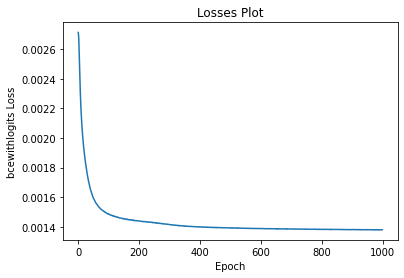

In [7]:
result2.plot_losses()
plt.show()

In [8]:
comp_models = ['StructuredEmbedding','TransE','RotatE','HolE']
comp_results = []
for comp_model in comp_models:
    print('Running {}'.format(comp_model))
    result = pipeline(
        dataset=dataset,
        model=comp_model,
        random_seed=1235,
        device='gpu',
        training_kwargs=dict(num_epochs=num_epochs),
        model_kwargs=dict(embedding_dim=embedding_dim),
        loss=loss,
        loss_kwargs=dict()
    )
    comp_results.append(result)

Running StructuredEmbedding


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


INFO:pykeen.evaluation.evaluator:Evaluation took 11.96s seconds



Running TransE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=512.


INFO:pykeen.evaluation.evaluator:Evaluation took 0.87s seconds



Running RotatE


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=128.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.15s seconds



Running HolE


/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:102: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  a_fft = torch.rfft(h, signal_ndim=1, onesided=True)
/home/gebhart/projects/pykeen/src/pykeen/models/unimodal/hole.py:112: UserWarning: The function torch.irfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.ifft or torch.fft.irfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:602.)
  composite = torch.irfft(p_fft, signal_ndim=1, onesided=True, signal_sizes=(h.shape[-1],))


INFO:pykeen.evaluation.evaluator:Starting batch_size search for evaluation now...


INFO:pykeen.evaluation.evaluator:Concluded batch_size search with batch_size=64.


INFO:pykeen.evaluation.evaluator:Evaluation took 1.61s seconds


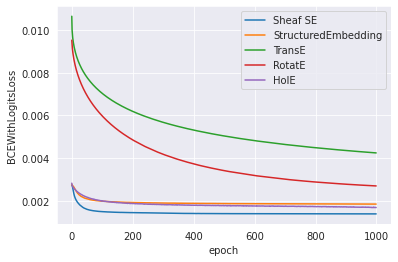

In [9]:
plt.plot(np.arange(len(result2.losses)),result2.losses,label='Sheaf SE')
for i in range(len(comp_models)):
    comp_model = comp_models[i]
    comp_result = comp_results[i]
    plt.plot(np.arange(len(comp_result.losses)),comp_result.losses,label=comp_model)
plt.ylabel(str(result.model.loss).replace('()',''))
plt.xlabel('epoch')
plt.legend()
plt.show()

In [10]:
res_df = result2.metric_results.to_df()

In [29]:
compto = 1

In [30]:
res_df['diff'] = res_df.Value - comp_results[compto].metric_results.to_df().Value
res_df

,Side,Type,Metric,Value,diff
0,both,avg,adjusted_mean_rank,0.514835,0.183359
1,head,avg,adjusted_mean_rank,0.582402,0.234475
2,tail,avg,adjusted_mean_rank,0.447267,0.132243
3,both,worst,mean_rank,10434.536423,3715.453830
4,both,worst,mean_reciprocal_rank,0.140582,0.031787
5,both,worst,hits_at_1,0.036423,0.033858
6,both,worst,hits_at_3,0.216655,0.030438
7,both,worst,hits_at_5,0.270178,0.028386
8,both,worst,hits_at_10,0.326265,0.031464
9,both,best,mean_rank,10434.535226,3715.457250


In [13]:
# comp_results[0].model.score_all_triples()

In [14]:
# model2.score_all_triples()